# Modelos QSAR-SVM para protease principal 3C-like protease (M<sup>pro</sup>) de SARS-CoV

Os modelos nesse fluxo de trabalho foram criados usando as impressões digitais de Morgan com SVM scikit-learn.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import _pickle as cPickle
import gzip
import seaborn as sns

#BalanceBySim: função de balanceamento de conjunto de dados (Equilibre os dados usando 1/2 similaridade e 1/2 aleatória)
from BalanceBySim import *
from time import time

#Stats: Calculos estatisticos referente ao modelo Kappa	CCR	Sensitivity	PPV	Specificity	NPV	Coverage
from stats import *

from collections import Counter

#RDKit: Bibliotecas p/ Cheminformatics de Código Aberto
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

#Sklearn: Bibliotecas p/ Machine learning de Código Aberto
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score # biblioteca GridSearch e RandomizedSearch e cross_validate
from sklearn.model_selection import permutation_test_score, StratifiedKFold
from sklearn.metrics import classification_report
def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

ModuleNotFoundError: No module named 'BalanceBySim'

## Carregar dados

Original data:  (113, 11)
Dados mantidos:  (113, 11)


,Compound_name,Standard Type,Standard Relation,Standard Value,Standard Units,Outcome,InChIKey,Molecule ChEMBL ID,ID,SMILES,Mol
count,113,113,113,113,113,113,113,113,113,113,113
unique,74,2,4,94,1,2,113,92,1,113,113
top,,IC50,'=',2.44889419684223E12,nM,Inactive,RPPFHWBHHCJZJS-UHFFFAOYSA-N,,,Cc1noc(NC(=O)c2ccc(-c3cc(C(F)(F)F)nn3C)s2)c1[N...,
freq,8,88,89,5,113,73,1,22,113,1,1

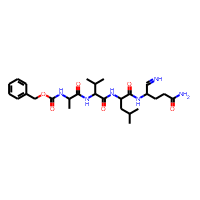

In [6]:
# Definir caminho do arquivo
file = 'datasets/curated_data/chembl-pdb-sars-cov-3C-like-proteinase.sdf.gz'
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
moldf = PandasTools.LoadSDF(file, **sdfInfo)
print('Original data: ', moldf.shape)

# Renomear ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})

# Remover moléculas RDKit ausentes
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')
    
# Colunas
print('Dados mantidos: ', moldf.shape)
moldf.describe()

## Forma dos dados

In [7]:
moldf['Outcome'] = moldf['Outcome'].replace('Active', 1)
moldf['Outcome'] = moldf['Outcome'].replace('Inactive', 0)

classes = Counter(moldf['Outcome'])
print('\033[1m' + 'Forma do conjunto de treinamento:' + '\n' + '\033[0m')
for key, value in classes.items():
    print('\t\t Classe %d: %d' % (key, value))
print('\t\t Número total de compostos: %d' % (len(moldf['Outcome'])))

Forma do conjunto de treinamento:

		 Classe 1: 40
		 Classe 0: 73
		 Número total de compostos: 113


# Calcular impressões digitais de Morgan

In [8]:
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

# Conjunto de treinamento
desc = moldf.Mol.apply(calcfp)
descriptors = desc.columns.difference(moldf.columns).tolist()
desc.shape

(113, 2048)

In [10]:
moldf_desc = pd.concat([moldf,desc], axis=1)
balance_data = 'no'

if balance_data == 'yes':
    # Equilibre os dados usando 1/2 similaridade e 1/2 aleatória
    moldf_desc = BalanceBySim(moldf_desc, 'Outcome', 2)
    # Forma de impressão
    print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))
      
else:
    moldf_desc['Set'] = 'train'
    # Forma de impressão
    print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))

Forma do conjunto de treinamento: Counter({0: 73, 1: 40})
Forma externa definida: Counter()


In [11]:
moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]

y_train = moldf_train['Outcome'].to_numpy()
X_train = moldf_train[descriptors]
X_train.shape

(113, 2048)

In [12]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Modelo com classificação: {0}".format(i))
            print("Escore médio de validação: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parametros: {0}".format(results['params'][candidate]))
            print("")

## Construção de modelo

### Pesquisa em grade (Grid Search)

In [13]:
def grid_search(clf_rf, rf_params, X_train, y_train):
    n_iter_search = 20
    # configuração detalhada = 10 imprimirá o progresso para cada 10 tarefas concluídas
    grid = GridSearchCV(clf_rf, rf_params, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
    
    start = time()
    grid.fit(X_train, y_train)
    print("GridSearchCV levou %.2f segundos para %d candidatos"
      " configurações de parâmetros." % ((time() - start), n_iter_search))
    report(grid.cv_results_)

    return grid

### Pesquisa aleatória (Random Search)

In [14]:
def random_search(clf_rf, param_dist, X_train, y_train):
    n_iter_search = 80
    random_search = RandomizedSearchCV(clf_rf, param_distributions=param_dist, 
                                       n_iter=n_iter_search, verbose=1, n_jobs=-1)
    
    start = time()
    random_search.fit(X_train, y_train)
    print("RandomizedSearchCV levou %.2f segundos para %d candidatos"
      " configurações de parâmetros." % ((time() - start), n_iter_search))
    report(random_search.cv_results_)

    return random_search

### Dados de modelagem

In [82]:
kernel = ['rbf', 'linear', 'sigmoid', 'poly']
class_weight = [100, 250, 500, 750, 1000]
gamma = [0.1, 0.01, 0.001, 0.0001, 0.00001]
random_state = [24]

# Crie a grade aleatória
random_param = {'kernel': kernel,
              'C': class_weight,
              'gamma': gamma,
              'random_state': random_state}

clf_svc = SVC(random_state=24).fit(X_train, y_train)

svc_random = random_search(clf_svc, random_param, X_train, y_train);

grid_params = {
    'kernel': [svc_random.best_params_['kernel']],
    'random_state': [svc_random.best_params_['random_state']], 
    'gamma': [svc_random.best_params_['gamma'] - 0.1, 
         svc_random.best_params_['gamma'] - 0.01, 
         svc_random.best_params_['gamma'], 
         svc_random.best_params_['gamma'] + 0.1, 
         svc_random.best_params_['gamma'] + 0.01,
             'auto'],
    'C': [svc_random.best_params_['C'] - 150, 
         svc_random.best_params_['C'] - 100, 
         svc_random.best_params_['C'], 
         svc_random.best_params_['C'] + 100, 
         svc_random.best_params_['C'] + 150]
}

svc_grid = grid_search(clf_svc, grid_params, X_train, y_train);

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RandomizedSearchCV levou 6.30 segundos para 80 candidatos configurações de parâmetros.
Modelo com classificação: 1
Escore médio de validação: 0.824 (std: 0.054)
Parametros: {'random_state': 24, 'kernel': 'poly', 'gamma': 0.01, 'C': 500}

Modelo com classificação: 1
Escore médio de validação: 0.824 (std: 0.054)
Parametros: {'random_state': 24, 'kernel': 'poly', 'gamma': 0.01, 'C': 750}

Modelo com classificação: 1
Escore médio de validação: 0.824 (std: 0.054)
Parametros: {'random_state': 24, 'kernel': 'poly', 'gamma': 0.01, 'C': 250}

Modelo com classificação: 1
Escore médio de validação: 0.824 (std: 0.054)
Parametros: {'random_state': 24, 'kernel': 'poly', 'gamma': 0.01, 'C': 1000}

Modelo com classificação: 1
Escore médio de validação: 0.824 (std: 0.054)
Parametros: {'random_state': 24, 'kernel': 'poly', 'gamma': 0.1, 'C': 100}

Modelo com classificação: 1
Escore médio de validação: 0.824 (std: 0.054)
Parametros: {'random_state': 24, 'kernel': 'poly', 'gamma': 0.1, 'C': 500}

Modelo c

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.5s finished


GridSearchCV levou 2.68 segundos para 20 candidatos configurações de parâmetros.
Modelo com classificação: 1
Escore médio de validação: 0.875 (std: 0.056)
Parametros: {'C': 350, 'gamma': 0.01, 'kernel': 'poly', 'random_state': 24}

Modelo com classificação: 1
Escore médio de validação: 0.875 (std: 0.056)
Parametros: {'C': 350, 'gamma': 0.11, 'kernel': 'poly', 'random_state': 24}

Modelo com classificação: 1
Escore médio de validação: 0.875 (std: 0.056)
Parametros: {'C': 350, 'gamma': 0.02, 'kernel': 'poly', 'random_state': 24}

Modelo com classificação: 1
Escore médio de validação: 0.875 (std: 0.056)
Parametros: {'C': 400, 'gamma': 0.01, 'kernel': 'poly', 'random_state': 24}

Modelo com classificação: 1
Escore médio de validação: 0.875 (std: 0.056)
Parametros: {'C': 400, 'gamma': 0.11, 'kernel': 'poly', 'random_state': 24}

Modelo com classificação: 1
Escore médio de validação: 0.875 (std: 0.056)
Parametros: {'C': 400, 'gamma': 0.02, 'kernel': 'poly', 'random_state': 24}

Modelo com cl

Baseline = 0.82

Best param - Random search: {'random_state': 24, 'kernel': 'poly', 'gamma': 0.01, 'C': 500}
Random search = 0.82

Best param - Grid search: {'C': 350, 'gamma': 0.01, 'kernel': 'poly', 'random_state': 24}
Grid search = 0.87


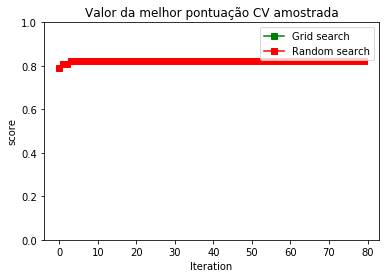

In [99]:
baseline = cross_val_score(clf_svc, X_train, y_train).mean()
y_gs = np.maximum.accumulate(svc_grid.cv_results_['mean_test_score'])
y_rs = np.maximum.accumulate(svc_random.cv_results_['mean_test_score'])

print(f'Baseline = {baseline:.2f}')

print()
print('Best param - Random search: %s' % svc_random.best_params_)
print(f'Random search = %.2f' % svc_random.best_score_)

print()
print('Best param - Grid search: %s' % svc_grid.best_params_)
print(f'Grid search = %.2f' % svc_grid.best_score_)

plt.plot(y_gs, 'gs-', label='Grid search')
plt.plot(y_rs, 'rs-', label='Random search')
plt.xlabel('Iteration')
plt.ylabel('score')
plt.ylim(0, 1)
plt.title('Valor da melhor pontuação CV amostrada');
plt.legend();

##### Modelo com w/ melhores parâmetros

In [84]:
svc_best = SVC(C=350, gamma=0.01, kernel='poly', random_state = 24, probability=True)
svc_best.fit(X_train, y_train)

SVC(C=350, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
    max_iter=-1, probability=True, random_state=24, shrinking=True, tol=0.001,
    verbose=False)

##### Validação cruzada 5 vezes

In [85]:
# Parametros
pred = []
ad = []
index = []
cross_val = StratifiedKFold(n_splits=5)

# Faça um loop de 5 vezes
for train_index, test_index in cross_val.split(X_train, y_train):    
    fold_model = svc_best.fit(X_train.iloc[train_index], y_train[train_index])
    fold_pred = svc_best.predict(X_train.iloc[test_index])
    fold_ad = svc_best.predict_proba(X_train.iloc[test_index])
    pred.append(fold_pred)
    ad.append(fold_ad)
    index.append(test_index)

In [86]:
threshold_ad = 0.70

# Preparar resultados para exportar    
fold_index = np.concatenate(index)    
fold_pred = np.concatenate(pred)
fold_ad = np.concatenate(ad)
fold_ad = (np.amax(fold_ad, axis=1) >= threshold_ad).astype(str)
five_fold_morgan = pd.DataFrame({'Prediction': fold_pred,'AD': fold_ad}, index=list(fold_index))
five_fold_morgan.AD[five_fold_morgan.AD == 'False'] = np.nan
five_fold_morgan.AD[five_fold_morgan.AD == 'True'] = five_fold_morgan.Prediction
five_fold_morgan.sort_index(inplace=True)
five_fold_morgan['y_train'] = pd.DataFrame(y_train)
five_fold_ad = five_fold_morgan.dropna().astype(int)
coverage_5f = len(five_fold_ad) / len(five_fold_morgan)


# estatísticas de morgan
morgan = pd.DataFrame(stats(five_fold_morgan['y_train'], five_fold_morgan['Prediction']))
morgan['Coverage'] = 1.0

# estatísticas do morgan AD
morgan_ad = five_fold_morgan.dropna(subset=['AD']).astype(int)
coverage_morgan_ad = len(morgan_ad['AD']) / len(five_fold_morgan['y_train'])
morgan_ad = pd.DataFrame(stats(morgan_ad['y_train'], morgan_ad['AD']))
morgan_ad['Coverage'] = round(coverage_morgan_ad, 2)

# imprimir estatísticas
print('\033[1m' + 'Características estatísticas de validação cruzada externa de 5 vezes dos modelos QSAR desenvolvidos morgan' + '\n' + '\033[0m')
morgan_5f_stats = morgan.append(morgan_ad)
morgan_5f_stats.set_index([['Morgan', 'Morgan AD']], drop=True, inplace=True)
morgan_5f_stats

Características estatísticas de validação cruzada externa de 5 vezes dos modelos QSAR desenvolvidos morgan



,Kappa,CCR,Sensibilidade,PPV,Especificidade,NPV,Accuracy,F1 Score,Coverage
Morgan,0.59,0.78,0.65,0.81,0.92,0.83,0.82,0.72,1.00
Morgan AD,0.71,0.83,0.71,0.89,0.96,0.87,0.88,0.79,0.65


##### Prever conjunto retido externo após o balanceamento

In [87]:
moldf_ext = moldf_desc[(moldf_desc['Set'] == 'ext')]
descriptor_list = list(X_train.columns.values)

if len(moldf_ext) > 0:
    y_ext = moldf_ext['Outcome'].to_numpy()
    X_ext = moldf_ext[descriptors]
    
    # Filtrar descritores não presentes no modelo
    X_ext = X_ext[descriptor_list]
    
    # Fazer previsões
    ext_set = svc_best.predict(X_ext)
    ext_set_ad = svc_best.predict_proba(X_ext)
    ext_set_ad = (np.amax(ext_set_ad, axis=1) >= threshold_ad).astype(str)
    
    # Preparar dados
    ext_set = pd.DataFrame({'Prediction': ext_set,'AD': ext_set_ad})
    ext_set.AD[ext_set.AD == 'False'] = np.nan
    ext_set.AD[ext_set.AD == 'True'] = ext_set.Prediction
    ext_set.sort_index(inplace=True)
    ext_set['y_ext'] = pd.DataFrame(y_ext)
    ext_set_ad = ext_set.dropna().astype(int)
    coverage_ext = len(ext_set_ad) / len(ext_set)
    
    # Imprimir estatísticas
    ext_set_stats = pd.DataFrame(stats(ext_set.y_ext, ext_set.Prediction))
    ext_set_stats['Coverage'] = 1.0
    print('External withheld set: \n', ext_set_stats.to_string(index=False), '\n')
    ext_set_stats_ad = pd.DataFrame(stats(ext_set_ad.y_ext, ext_set_ad.AD))
    ext_set_stats_ad['Coverage'] = round(coverage_ext, 2)
    print('External withheld set with AD: \n', ext_set_stats_ad.to_string(index=False), '\n')
else:
    pass

##### Y-randomização

In [88]:
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(svc_best, X_train, y_train,
                                                           cv=5, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


True score =  0.78 
Y-randomization =  0.51 
p-value =  0.0476


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.6s finished


##### Salvar modelo

In [89]:
with gzip.GzipFile('model/sars-cov-3clpro-morgan_SVM_ad_balanced.pgz', 'w') as f:
    cPickle.dump(svc_best, f)

### Exportar previsões

In [90]:
pred_train = moldf_train[moldf_train.columns.difference(descriptor_list)]
pred_train.reset_index(inplace=True)
five_fold_exp = five_fold_morgan[['Prediction', 'AD']].rename(columns={'Prediction':'morgan', 'AD':'morgan_ad'}, )
pred_train = pd.concat([pred_train, five_fold_exp], axis=1)
pred_train['Set'] = 'train'

if len(moldf_ext) > 0:
    pred_ext = moldf_ext[moldf_ext.columns.difference(descriptor_list)]
    pred_ext.reset_index(inplace=True)
    ext_set_exp = ext_set[['Prediction', 'AD']].rename(columns={'Prediction':'morgan', 'AD':'morgan_ad'}, )
    pred_ext = pd.concat([pred_ext, ext_set_exp], axis=1)
    pred_ext['Set'] = 'ext'
    
    pred_morgan = pd.concat([pred_train, pred_ext], axis=0).sort_values(by='index')
    pred_morgan.drop(columns=['index', 'Mol', 'ID'], inplace=True)

else:
    pred_morgan = pred_train.copy()
    pred_morgan.drop(columns=['index', 'Mol', 'ID'], inplace=True)
    
#for col in ['Outcome', 'morgan', 'morgan_ad']:
#    pred_morgan[col].replace(0,'Inactive', inplace=True)
#    pred_morgan[col].replace(1,'Active', inplace=True)

In [91]:
with pd.ExcelWriter('predictions-svm-morgan.xlsx') as writer:
    pred_morgan.to_excel(writer, sheet_name='morgan', index=False)

### Plotando as Estatísticas

In [92]:
# Exportar estatísticas
if len(moldf_ext) > 0:
    morgan_stats = pd.concat([morgan, morgan_ad], axis=0)
    morgan_stats.set_index([['5-fold CV', 'External withheld set']], drop=True, inplace=True)
    morgan_stats
else:
    morgan_stats = morgan_5f_stats.copy()
    morgan_stats

,Kappa,CCR,Sensibilidade,PPV,Especificidade,NPV,Accuracy,F1 Score,Coverage
Morgan,0.59,0.78,0.65,0.81,0.92,0.83,0.82,0.72,1.00
Morgan AD,0.71,0.83,0.71,0.89,0.96,0.87,0.88,0.79,0.65


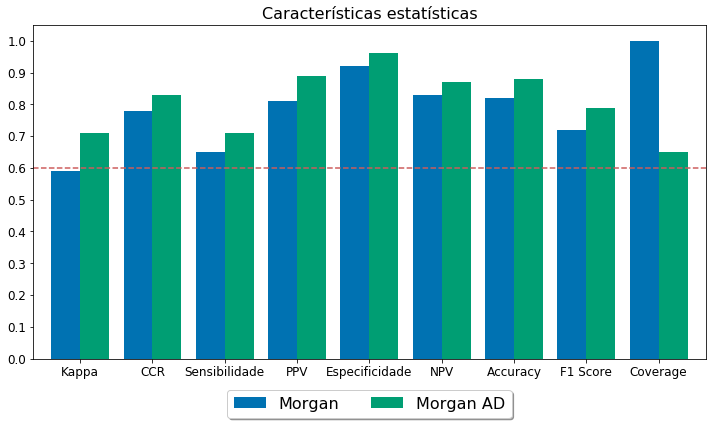

In [93]:
# Estatísticas de transposição
morgan_stats_t = morgan_stats.T
morgan_stats_t = morgan_stats_t.reset_index()
morgan_stats_t = morgan_stats_t.rename(columns={'index': 'Stats'})

# Fazer enredo
plt.style.use('seaborn-colorblind')
fig, ax1 = plt.subplots(figsize=(10,6))

morgan_stats_t.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xticklabels(labels=morgan_stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')# xmin=0.25, xmax=0.75)
ax1.legend_.remove()
plt.title('Características estatísticas', fontsize=16)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=12)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=16,
            loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True,
            shadow=True, ncol=2)
fig.tight_layout()

plt.savefig('statistics-morgan.png', bbox_inches='tight',
            transparent=False, format='png', dpi=300)
plt.show();